In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [8]:
df = pd.read_csv('Corona_NLP_train.csv',encoding='ISO-8859-1')
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [9]:
df.shape

(41157, 6)

In [10]:
df.drop(['UserName','ScreenName','Location','TweetAt'], axis=1, inplace=True)
df.head()

,OriginalTweet,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [11]:
df['OriginalTweet'][0]

'@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8'

In [12]:
import re
import spacy
nlp = spacy.load('en_core_web_sm')

def clean_text(text):
# RE

    text = text.lower()

    # remove html tags
    text = re.sub(r'<.*?>', '', text)

    # Remove URLs and links (http, https, www)
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)

    # remove mentions
    text = re.sub(r'@\w+',' ',text)

    # # remove hastags
    text = re.sub(r'#\w+', ' ', text)

    # Remove anything that is not a character (retain letters and spaces only)
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Remove leading/trailing spaces
    text = text.strip()

    # Remove extra spaces (collapse multiple spaces into a single space)
    text = re.sub(r'\s+', ' ', text)

# NLP

    doc = nlp(text)

    cleaned_txt = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]

    text = ' '.join(cleaned_txt)

    return text

In [14]:
df['cleaned_text'] = df['OriginalTweet'].apply(clean_text)
df.head()

,OriginalTweet,Sentiment,cleaned_text
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,
1,advice Talk to your neighbours family to excha...,Positive,advice talk neighbour family exchange phone nu...
2,Coronavirus Australia: Woolworths to give elde...,Positive,coronavirus australia woolworth elderly disabl...
3,My food stock is not the only one which is emp...,Positive,food stock not panic food need stay calm stay ...
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative,ready supermarket outbreak m paranoid food sto...


In [15]:
df['cleaned_text'] = df['cleaned_text'].apply(lambda x: x if len(x) != 0 else None)
df.head()

,OriginalTweet,Sentiment,cleaned_text
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,None
1,advice Talk to your neighbours family to excha...,Positive,advice talk neighbour family exchange phone nu...
2,Coronavirus Australia: Woolworths to give elde...,Positive,coronavirus australia woolworth elderly disabl...
3,My food stock is not the only one which is emp...,Positive,food stock not panic food need stay calm stay ...
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative,ready supermarket outbreak m paranoid food sto...


In [16]:
df.isna().sum()

,0
OriginalTweet,0
Sentiment,0
cleaned_text,70


In [17]:
df.dropna(inplace=True)
df.shape

(41087, 3)

In [18]:
X = df['cleaned_text']
y = df['Sentiment']

In [19]:
y.value_counts()

,count
Sentiment,
Positive,11420
Negative,9912
Neutral,7650
Extremely Positive,6624
Extremely Negative,5481


In [20]:
# Ordinal encode
Ordinal_y = y.map({'Extremely Negative':0,'Negative':0,'Neutral':1,'Positive':2,'Extremely Positive':2})
Ordinal_y.value_counts()

,count
Sentiment,
2,18044
0,15393
1,7650


In [21]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,Ordinal_y,test_size=0.2,stratify=y)

###TFidfVectorizer

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

td_idf = TfidfVectorizer(ngram_range=(1,2))
x_train_td_idf = td_idf.fit_transform(X_train)
x_test_td_idf = td_idf.transform(X_test)

#Machine Learning

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.model_selection import GridSearchCV

estimator = {
    'MultinomialNB': MultinomialNB(),
    'LinearSVC': LinearSVC()
}

params = {
    'MultinomialNB': {},
    'LinearSVC': {'C': [0.001,0.01,0.1, 1, 10, 100]}
}


best_estimator = {}
for name, model in estimator.items():
  model = GridSearchCV(model, params[name], cv=5)
  model.fit(x_train_td_idf,y_train)
  model.predict(x_test_td_idf)
  print(f"{name} Accuracy: {accuracy_score(y_test,model.predict(x_test_td_idf))}")
  best_estimator[name] = model.best_estimator_

MultinomialNB Accuracy: 0.6331224142127038
LinearSVC Accuracy: 0.7964224872231687


In [ ]:
best_model = best_estimator['LinearSVC']
y_pred = best_model.predict(x_test_td_idf)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.80      0.82      0.81      3079
           1       0.78      0.56      0.65      1530
           2       0.80      0.88      0.83      3609

    accuracy                           0.80      8218
   macro avg       0.79      0.75      0.77      8218
weighted avg       0.80      0.80      0.79      8218



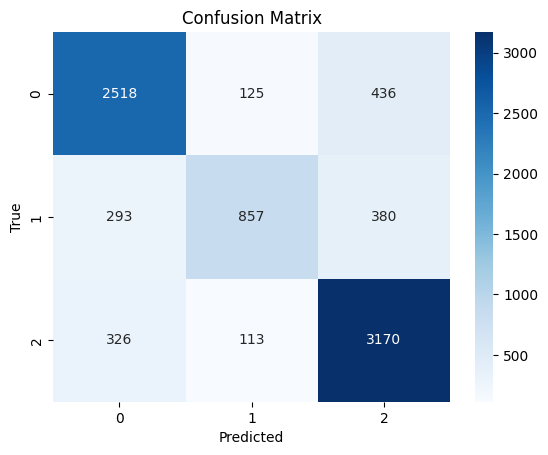

In [ ]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

#LSTM

In [22]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, GlobalAveragePooling1D

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [23]:
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [24]:
mx_len = max(len(x.split()) for x in X_train)

X_train_pad = pad_sequences(X_train_seq,maxlen=mx_len)
X_test_pad = pad_sequences(X_test_seq,maxlen=mx_len)

In [41]:
num_words = len(tokenizer.word_index) + 1

model = Sequential()
model.add(Embedding(num_words,128,input_length=mx_len))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(128,return_sequences=True)))
model.add(Dropout(0.5))
model.add(GlobalAveragePooling1D())
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3,activation='softmax'))

model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [42]:
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau

early_stop = EarlyStopping(monitor='val_loss',patience=5)
reduce_lr = ReduceLROnPlateau(monitor='val_loss',factor=0.2,patience=2)
model_checkpoint = ModelCheckpoint('best_model.keras',monitor='val_loss',save_best_only=True)

model.fit(X_train_pad,y_train,validation_split=0.2,epochs=10,batch_size=64,callbacks=[early_stop,reduce_lr,model_checkpoint])

Epoch 1/10
411/411 ━━━━━━━━━━━━━━━━━━━━ 110s 244ms/step - accuracy: 0.5147 - loss: 0.9538 - val_accuracy: 0.7692 - val_loss: 0.6041 - learning_rate: 0.0010
Epoch 2/10
411/411 ━━━━━━━━━━━━━━━━━━━━ 153s 271ms/step - accuracy: 0.8261 - loss: 0.4963 - val_accuracy: 0.8118 - val_loss: 0.5226 - learning_rate: 0.0010
Epoch 3/10
411/411 ━━━━━━━━━━━━━━━━━━━━ 129s 239ms/step - accuracy: 0.8878 - loss: 0.3529 - val_accuracy: 0.8123 - val_loss: 0.5301 - learning_rate: 0.0010
Epoch 4/10
411/411 ━━━━━━━━━━━━━━━━━━━━ 95s 231ms/step - accuracy: 0.9063 - loss: 0.2950 - val_accuracy: 0.8162 - val_loss: 0.5276 - learning_rate: 0.0010
Epoch 5/10
411/411 ━━━━━━━━━━━━━━━━━━━━ 144s 235ms/step - accuracy: 0.9341 - loss: 0.2186 - val_accuracy: 0.8153 - val_loss: 0.6020 - learning_rate: 2.0000e-04
Epoch 6/10
411/411 ━━━━━━━━━━━━━━━━━━━━ 140s 229ms/step - accuracy: 0.9391 - loss: 0.1981 - val_accuracy: 0.8123 - val_loss: 0.6131 - learning_rate: 2.0000e-04
Epoch 7/10
411/411 ━━━━━━━━━━━━━━━━━━━━ 99s 241ms/step - 

In [43]:
import tensorflow as tf

best_model = tf.keras.models.load_model('best_model.keras')
best_model.evaluate(X_test_pad,y_test)

257/257 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.8102 - loss: 0.5298


[0.5102558732032776, 0.8211243748664856]

In [47]:
from sklearn.metrics import classification_report

y_pred = best_model.predict(X_test_pad)
y_pred = np.argmax(y_pred,axis=1)
print(classification_report(y_test,y_pred))

257/257 ━━━━━━━━━━━━━━━━━━━━ 18s 71ms/step
              precision    recall  f1-score   support

           0       0.81      0.84      0.82      3079
           1       0.79      0.74      0.76      1530
           2       0.84      0.84      0.84      3609

    accuracy                           0.82      8218
   macro avg       0.82      0.81      0.81      8218
weighted avg       0.82      0.82      0.82      8218



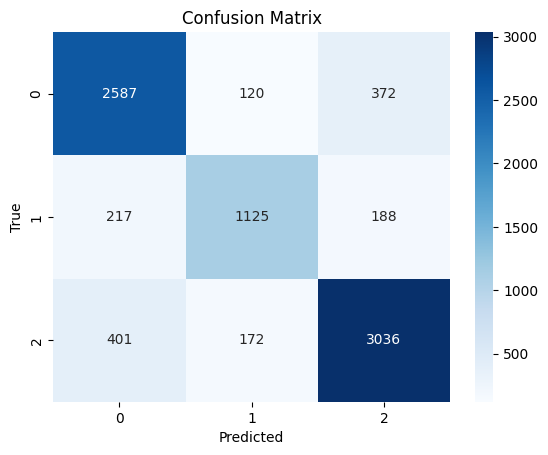

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()